### Creating an automated meeting minutes generator with Whisper and GPT-4
https://platform.openai.com/docs/tutorials/meeting-minutes

OpenAI's Whisper and GPT-4 models to develop an automated meeting minutes generator. The application transcribes audio from a meeting, provides a summary of the discussion, extracts key points and action items, and performs a sentiment analysis.

Additionally, you will need to install the python-docx and OpenAI libraries.
python-docx is a Python library for creating and updating Microsoft Word (.docx) files.

You can create a new Python environment and install the required packages with the following commands:

In [ ]:
#python -m venv env
#source env/bin/activate

In [ ]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.7 MB/s eta 0:00:00


In [ ]:
!pip install python-docx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184487 sha256=f703b089fef60e28f783c0d272b3048cabf43d25c7ca9d2dd66f565d0d9ebca0
  Stored in directory: /root/.cache/pip/wheels/80/27/06/837436d4c3bd989b957a91679966f207bfd71d358d63a8194d
Successfully built python-docx


### Transcribing audio with Whisper

The first step in transcribing the audio from a meeting is to pass the audio file of the meeting into our /v1/audio API. Whisper, the model that powers the audio API, is capable of converting spoken language into written text. To start, we will avoid passing a prompt or temperature (optional parameters to control the model's output) and stick with the default values.

Next, we import the required packages and define a function that uses the Whisper model to take in the audio file and transcribe it:

In [ ]:
import openai
from docx import Document

In [ ]:
def transcribe_audio(audio_file_path):
  with open(audio_file_path, 'rb') as audio_file:
    transcription = openai.Audio.transcribe(model='whisper-1', file=audio_file)
  return transcription#['text']

In this function, audio_file_path is the path to the audio file you want to transcribe. The function opens this file and passes it to the Whisper ASR model (whisper-1) for transcription. The result is returned as raw text. It’s important to note that the openai.Audio.transcribe function requires the actual audio file to be passed in, not just the path to the file locally or on a remote server. This means that if you are running this code on a server where you might not also be storing your audio files, you will need to have a preprocess step that first downloads the audio files onto that device.

### Summarizing and analyzing the transcript with GPT-4

Having obtained the transcript, we now pass it to GPT-4 via the Chat completions API. GPT-4 is OpenAI's state-of-the-art large language model which we'll use to generate a summary, extract key points, action items, and perform sentiment analysis.

This tutorial uses distinct functions for each task we want GPT-4 to perform. This is not the most efficient way to do this task - you can put these instructions into one function, however, splitting them up can lead to higher quality summarization.

To split the tasks up, we define the meeting_minutes function which will serve as the main function of this application:

In [ ]:
def meeting_minutes(transcription):
  abstract_summary = abstract_summary_extraction(transcription)
  key_points = key_points_extraction(transcription)
  action_items = action_item_extraction(transcription)
  sentiment = sentiment_analysis(transcription)

  return {
      'abstract_summary': abstract_summary,
      'key_points': key_points,
      'action_items': action_items,
      'sentiment': sentiment
  }

In this function, transcription is the text we obtained from Whisper. The transcription can be passed to the four other functions, each designed to perform a specific task: abstract_summary_extraction generates a summary of the meeting, key_points_extraction extracts the main points, action_item_extraction identifies the action items, and sentiment_analysis performs a sentiment analysis. If there are other capabilities you want, you can add those in as well using the same framework shown above.

### Summary extraction

The abstract_summary_extraction function takes the transcription and summarizes it into a concise abstract paragraph with the aim to retain the most important points while avoiding unnecessary details or tangential points. The main mechanism to enable this process is the system message as shown below. There are many different possible ways of achieving similar results through the process commonly referred to as prompt engineering. You can read our GPT best practices guide which gives in depth advice on how to do this most effectively.

In [ ]:
def abstract_summary_extraction(transcription):
    response = openai.ChatCompletion.create(
        model="gpt-4",
        temperature=0,
        messages=[
            {
                "role": "system",
                "content": """You are a highly skilled AI trained in language comprehension and summarization. \
                I would like you to read the following text and summarize it into a concise abstract paragraph. \
                Aim to retain the most important points, providing a coherent and readable summary \
                that could help a person understand the main points of the discussion without needing to read the entire text. \
                Please avoid unnecessary details or tangential points."""
            },
            {
                "role": "user",
                "content": transcription
            }
        ]
    )
    return response['choices'][0]['message']['content']

### Key points extraction

The key_points_extraction function identifies and lists the main points discussed in the meeting. These points should represent the most important ideas, findings, or topics crucial to the essence of the discussion. Again, the main mechanism for controlling the way these points are identified is the system message. You might want to give some additional context here around the way your project or company runs such as “We are a company that sells race cars to consumers. We do XYZ with the goal of XYZ”. This additional context could dramatically improve the models ability to extract information that is relevant.

In [ ]:

def key_points_extraction(transcription):
    response = openai.ChatCompletion.create(
        model="gpt-4",
        temperature=0,
        messages=[
            {
                "role": "system",
                "content": "You are a proficient AI with a specialty in distilling information into key points. \
                Based on the following text, identify and list the main points that were discussed or brought up. \
                These should be the most important ideas, findings, or topics that are crucial to the \
                essence of the discussion. Your goal is to provide a list that someone could read to quickly understand \
                what was talked about."
            },
            {
                "role": "user",
                "content": transcription
            }
        ]
    )
    return response['choices'][0]['message']['content']

### Action item extraction

The action_item_extraction function identifies tasks, assignments, or actions agreed upon or mentioned during the meeting. These could be tasks assigned to specific individuals or general actions the group decided to take. While not covered in this tutorial, the Chat completions API provides a function calling capability which would allow you to build in the ability to automatically create tasks in your task management software and assign it to the relevant person.

In [ ]:

def action_item_extraction(transcription):
    response = openai.ChatCompletion.create(
        model="gpt-4",
        temperature=0,
        messages=[
            {
                "role": "system",
                "content": "You are an AI expert in analyzing conversations and extracting action items. \
                Please review the text and identify any tasks, assignments, or actions that were agreed upon or \
                mentioned as needing to be done. These could be tasks assigned to specific individuals, or \
                general actions that the group has decided to take. Please list these action items clearly and concisely."
            },
            {
                "role": "user",
                "content": transcription
            }
        ]
    )
    return response['choices'][0]['message']['content']

### Sentiment analysis

The sentiment_analysis function analyzes the overall sentiment of the discussion. It considers the tone, the emotions conveyed by the language used, and the context in which words and phrases are used. For tasks which are less complicated, it may also be worthwhile to try out gpt-3.5-turbo in addition to gpt-4 to see if you can get a similar level of performance. It might also be useful to experiment with taking the results of the sentiment_analysis function and passing it to the other functions to see how having the sentiment of the conversation impacts the other attributes.

In [ ]:
def sentiment_analysis(transcription):
    response = openai.ChatCompletion.create(
        model="gpt-4",
        temperature=0,
        messages=[
            {
                "role": "system",
                "content": "As an AI with expertise in language and emotion analysis, your task is \
                to analyze the sentiment of the following text. Please consider the overall tone of the discussion, \
                the emotion conveyed by the language used, and the context in which words and phrases are used. \
                Indicate whether the sentiment is generally positive, negative, or neutral, and provide brief explanations \
                for your analysis where possible."
            },
            {
                "role": "user",
                "content": transcription
            }
        ]
    )
    return response['choices'][0]['message']['content']

### Exporting Meeting Minutes

Once we've generated the meeting minutes, it's beneficial to save them into a readable format that can be easily distributed. One common format for such reports is Microsoft Word. The Python docx library is a popular open source library for creating Word documents. If you wanted to build an end-to-end meeting minute application, you might consider removing this export step in favor of sending the summary inline as an email followup.

To handle the exporting process, define a function save_as_docx that converts the raw text to a Word document:

In [ ]:
def save_as_docx(minutes, filename):
  doc = Document()

  for key, value in minutes.items():
    # Replace underscores with spaces and capitalize each word for the heading
    heading = ' '.join(word.capitalize() for word in key.split('_'))
    doc.add_heading(heading, level=1)
    doc.add_paragraph(value)
    # Add a line break between sections
    doc.add_paragraph()

  doc.save(filename)

In this function, minutes is a dictionary containing the abstract summary, key points, action items, and sentiment analysis from the meeting. Filename is the name of the Word document file to be created. The function creates a new Word document, adds headings and content for each part of the minutes, and then saves the document to the current working directory.

In [ ]:
input_key = input('Please enter your OpenAI API Key: ')
openai.api_key = input_key

APIError: Maximum content size limit (26214400) exceeded (26335252 bytes read)

https://platform.openai.com/docs/guides/speech-to-text/longer-inputs

In [ ]:
!pip install pydub

In [ ]:
from pydub import AudioSegment

audio_file_path = 'sample.wav'
# 2:53 mins long in wav format and 50.7 MB

audio_file_segment = AudioSegment.from_mp3(audio_file_path)

# PyDub handles time in milliseconds
ten_minutes = 3 * 60 * 1000

first_3_minutes = audio_file_segment[:ten_minutes]

first_3_minutes.export("sample.mp3", format="mp3")
# 5:51 mins long in mp3 format and 2.8 MB

<_io.BufferedRandom name='EarningsCall.mp3'>

Finally, you can put it all together and generate the meeting minutes from an audio file:

In [ ]:
#audio_file_path = 'EarningsCall.wav'
audio_file_path = 'sample.mp3'

transcription = transcribe_audio(audio_file_path)

In [ ]:
transcription

<OpenAIObject at 0x7c5992cd2250> JSON: {
  "text": "Good afternoon, everyone, and welcome to FinTech Plus Sync's 2nd quarter 2023 earnings call. I'm John Doe, CEO of FinTech Plus. We've had a stellar Q2 with a revenue of $125 million, a 25% increase year over year. Our gross profit margin stands at a solid 58%, due in part to cost efficiencies gained from our scalable business model. Our EBITDA has surged to $37.5 million, translating to a remarkable 30% EBITDA margin. Our net income for the quarter rose to $16 million, which is a noteworthy increase from $10 million in Q2 2022. Our total addressable market has grown substantially, thanks to the expansion of our high-yield savings product line and the new RoboAdvisor platform. We've been diversifying our asset-backed securities portfolio, investing heavily in collateralized debt obligations and residential mortgage-backed securities. We've also invested $25 million in AAA-rated corporate bonds, enhancing our risk-adjusted returns. As f

In [ ]:
minutes = meeting_minutes(transcription['text'])

In [ ]:
minutes

{'abstract_summary': "FinTech Plus Sync reported a successful Q2 2023, with a 25% YoY increase in revenue to $125 million, a gross profit margin of 58%, and a 30% EBITDA margin. Net income rose to $16 million, up from $10 million in Q2 2022. The company's total addressable market expanded due to the introduction of a high-yield savings product line and a new RoboAdvisor platform. Investments were made in asset-backed securities, including collateralized debt obligations, residential mortgage-backed securities, and $25 million in AAA-rated corporate bonds. The company's total assets reached $1.5 billion, with total liabilities at $900 million, resulting in a solid equity base of $600 million. The company also reported a healthy debt-to-equity ratio of 1.5 and a Tier 1 capital ratio of 12.5%. The company expects Q3 revenue to be around $135 million, driven by blockchain solutions and AI-driven predictive analytics. The upcoming IPO of its fintech subsidiary, Pay Plus, is expected to rais

In [ ]:
save_as_docx(minutes, 'sample_Meeting_Minutes.docx')

This code will transcribe the audio file Earningscall.wav, generates the meeting minutes, prints them, and then saves them into a Word document called meeting_minutes.docx.

Now that you have the basic meeting minutes processing setup, consider trying to optimize the performance with prompt engineering or build an end-to-end system with native function calling.

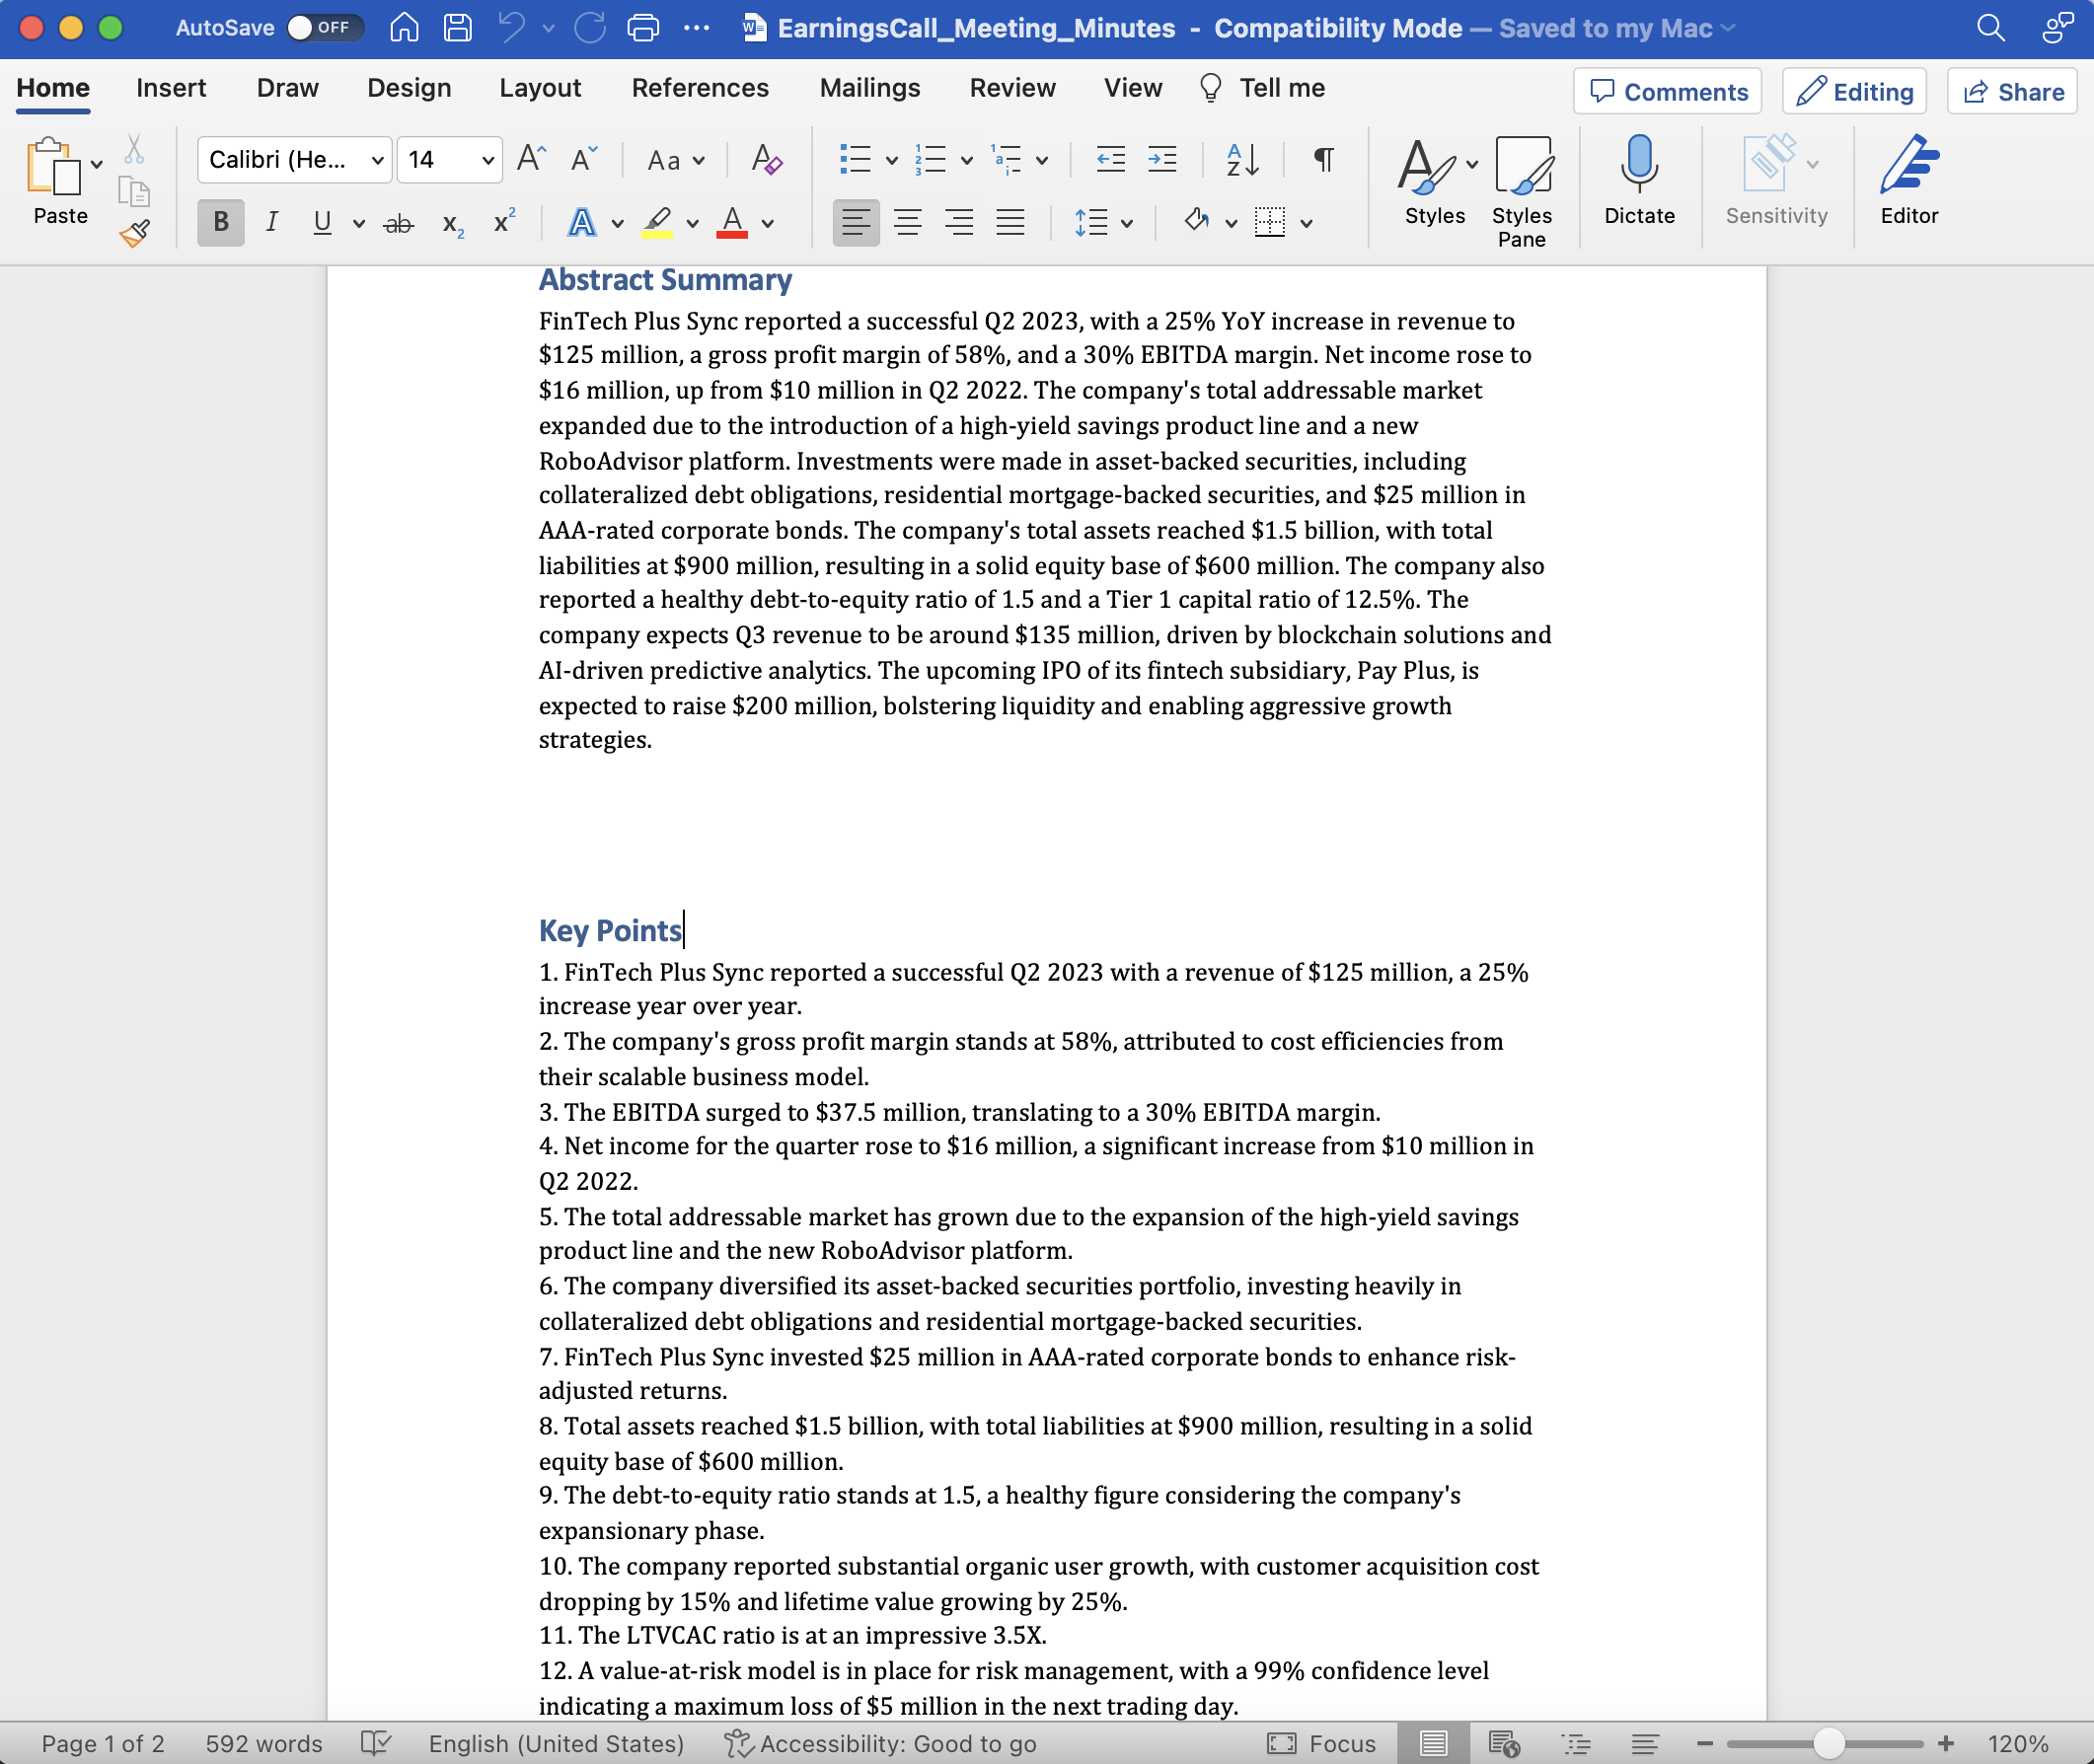

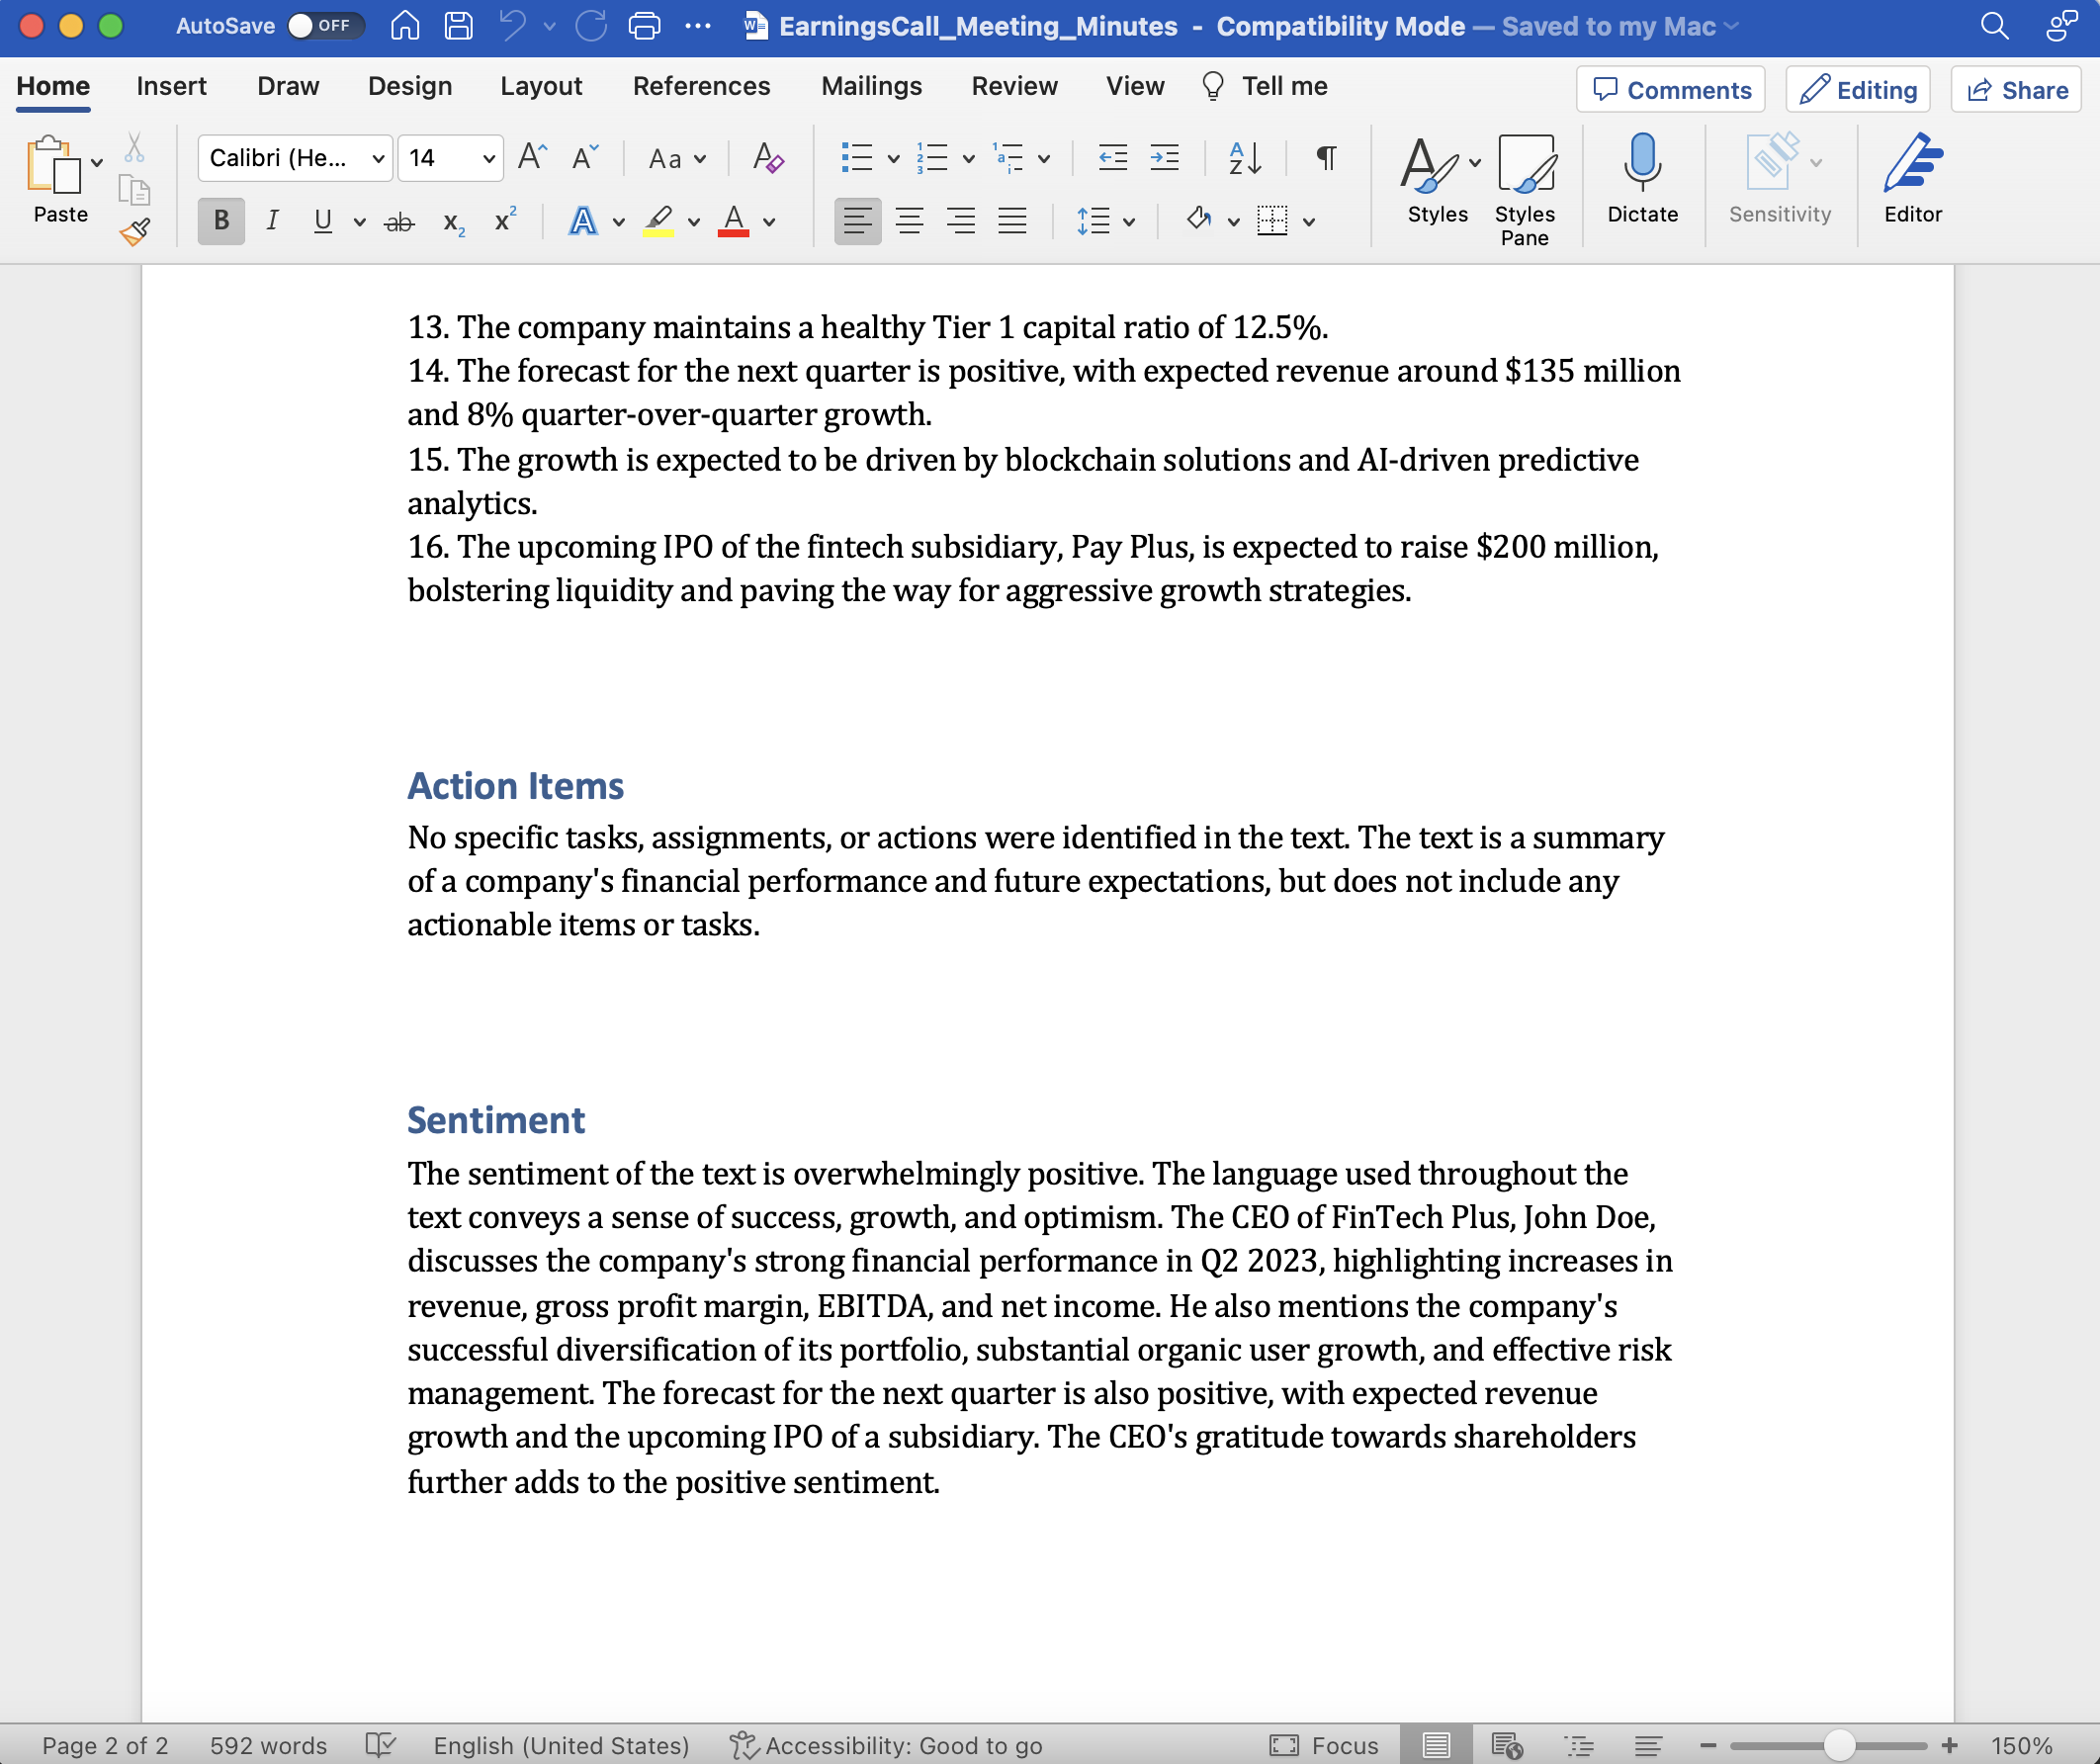